In [17]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [18]:
!pip install mplfinance

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spi

In [19]:
import os
_colab_dir = "/content/gdrive/MyDrive/Colab Notebooks"
os.chdir(_colab_dir)

In [20]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten, TimeDistributed, GRU
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras import activations
import random
import matplotlib.pyplot as plt

In [21]:
#!unzip '/content/gdrive/MyDrive/Colab Notebooks/training_data_5.csv.zip' -d '/content/gdrive/MyDrive/Colab Notebooks/';
#!unzip '/content/gdrive/MyDrive/Colab Notebooks/training_data_20.csv.zip' -d '/content/gdrive/MyDrive/Colab Notebooks/';

In [25]:
# Parameters for the model
NUM_EPOCHS = 100
HIDDEN_LAYER_SIZE = 256
BATCH_SIZE = 2048
LR = 10**(-3)
WINDOW_SIZES = [10]  # List of window sizes for training

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the base directory and file pattern
BASE_DIR = '/content/gdrive/MyDrive/Colab Notebooks/'
FILE_PATTERN = 'training_data_{}.csv'

# Function to preprocess the data
def preprocess_data(data_file, window_size):
    # Read data in chunks for memory efficiency
    chunk = pd.read_csv(data_file, header=0, chunksize=10000)
    df = pd.concat(chunk)


    # Separate labels from the data
    labels = df[['label']]
    df.drop('label', axis=1, inplace=True)

    # Indices for splitting data into train, validation and test sets
    train_cutoff = df.reset_index().query('date0 =="2019-12-31 18:00:00"').index[0]
    valid_cutoff = df.reset_index().query('date0 =="2021-12-31 18:00:00"').index[0]
    test_cutoff = df.reset_index().query('date0 =="2022-12-30 18:00:00"').index[0]

    # Drop 'date' columns as per the window size
    drop_list = ['date'+str(i) for i in range(window_size)]
    drop_list_open = ['open_base_SPX500'+str(i) for i in range(window_size)]
    drop_list_high = ['high_base_SPX500'+str(i) for i in range(window_size)]
    drop_list_low = ['low_base_SPX500'+str(i) for i in range(window_size)]
    drop_list_close = ['close_base_SPX500'+str(i) for i in range(window_size)]
    date_price_validation = df[valid_cutoff:test_cutoff]

    # Save date_price_validation to csv for future use
    df.drop(drop_list, axis=1, inplace=True)
    df.drop(drop_list_open, axis=1, inplace=True)
    df.drop(drop_list_high, axis=1, inplace=True)
    df.drop(drop_list_low, axis=1, inplace=True)
    df.drop(drop_list_close, axis=1, inplace=True)

    # Split data into train, validation and test sets
    X_train, X_valid, X_test = df[:train_cutoff], df[train_cutoff:valid_cutoff], df[valid_cutoff:test_cutoff]
    Y_train, Y_valid, Y_test = labels[:train_cutoff], labels[train_cutoff:valid_cutoff], labels[valid_cutoff:test_cutoff]

    # Print the shapes of each set for verification
    print(X_train.shape, X_valid.shape, X_test.shape)
    print(Y_train.shape, Y_valid.shape, Y_test.shape)

    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test, date_price_validation

def normalize_and_reshape(data, scaler, window_size):
    data = scaler.transform(data)
    data = data.reshape(data.shape[0], window_size, -1)
    return data

# Function to plot the model's training history
def plot_history(history, save_file):
    plt.rcdefaults()  # Add this line to reset the global state
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 grid for 4 plots

    # Loss plot for training data
    axs[0, 0].plot(history.history['mae'],
                   color='blue',
                   label='mae')
    axs[0, 0].set_title('MAE history')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Accuracy plot for training data
    axs[0, 1].plot(history.history['root_mean_squared_error'],
                   color='red',
                   label='rmse')  # Replace 'mae' with 'accuracy' if that's what you're using
    axs[0, 1].set_title('RMSE history')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # Loss plot for validation data of mae
    axs[1, 0].plot(history.history['val_mae'],
                   color='blue',
                   label='val_mae')
    axs[1, 0].set_title('Validation MAE history')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    # Accuracy plot for validation data
    axs[1, 1].plot(history.history['val_root_mean_squared_error'],
                   color='red',
                   label='val_rmse')  # Replace 'val_mae' with 'val_accuracy' if that's what you're using
    axs[1, 1].set_title('Validation RMSE history')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()

    # Save the full figure
    fig.tight_layout()
    fig.savefig(save_file)

In [26]:


def create_mlp_model(input_shape, HIDDEN_LAYER_SIZE, LR):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(HIDDEN_LAYER_SIZE, input_shape=input_shape, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(HIDDEN_LAYER_SIZE, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(HIDDEN_LAYER_SIZE, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

# CNNモデルの生成
def create_cnn_model(input_shape, HIDDEN_LAYER_SIZE, LR):
    model = Sequential()
    model.add(Conv1D(filters=HIDDEN_LAYER_SIZE, kernel_size=3, activation='swish', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())  # バッチ正規化を追加
    model.add(Dropout(0.5))  # ドロップアウトを追加
    model.add(Conv1D(filters=HIDDEN_LAYER_SIZE, kernel_size=1, activation='swish'))  # カーネルサイズを2に変更
    model.add(MaxPooling1D(pool_size=1))  # プーリングを行わない
    model.add(BatchNormalization())  # バッチ正規化を追加
    model.add(Dropout(0.5))  # ドロップアウトを追加
    model.add(Flatten())
    model.add(Dense(HIDDEN_LAYER_SIZE, activation='swish'))
    model.add(BatchNormalization())  # バッチ正規化を追加
    model.add(Dropout(0.5))  # ドロップアウトを追加
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

# LSTMモデルの生成
def create_lstm_model(input_shape, HIDDEN_LAYER_SIZE, LR):
    model = Sequential()
    model.add(LSTM(HIDDEN_LAYER_SIZE, activation='swish', dropout=0.5, recurrent_dropout=0.5, input_shape=input_shape))  # LSTMにドロップアウトを追加
    model.add(Dropout(0.5))
    model.add(Dense(HIDDEN_LAYER_SIZE, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

def create_stacked_lstm_model(input_shape, HIDDEN_LAYER_SIZE, LR):
    model = Sequential()
    model.add(LSTM(HIDDEN_LAYER_SIZE, activation='swish', return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=input_shape))
    model.add(LSTM(HIDDEN_LAYER_SIZE, activation='swish', return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(LSTM(HIDDEN_LAYER_SIZE, activation='swish', dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.5))
    model.add(Dense(HIDDEN_LAYER_SIZE, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

def create_gru_model(input_shape, HIDDEN_LAYER_SIZE, LR):
    model = Sequential()
    model.add(GRU(HIDDEN_LAYER_SIZE, activation='swish', dropout=0.5, recurrent_dropout=0.5, input_shape=input_shape))  # LSTMにドロップアウトを追加
    model.add(Dropout(0.5))
    model.add(Dense(HIDDEN_LAYER_SIZE, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

def create_bilstm_model(input_shape, HIDDEN_LAYER_SIZE, LR):
    model = Sequential()
    model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, activation='swish', dropout=0.5, recurrent_dropout=0.5), input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(HIDDEN_LAYER_SIZE, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

def create_stacked_bilstm_model(input_shape, HIDDEN_LAYER_SIZE, LR):
    model = Sequential()
    model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, activation='swish', dropout=0.5, recurrent_dropout=0.5, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, activation='swish', dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, activation='swish', dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dropout(0.5))
    model.add(Dense(HIDDEN_LAYER_SIZE, activation='swish'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

def create_transformer_model(input_shape, HIDDEN_LAYER_SIZE, LR, n_heads=2, n_enc_layers=2, n_dec_layers=2):
    # Encoder
    encoder_inputs = Input(shape=input_shape)
    encoder = MultiHeadAttention(num_heads=n_heads, key_dim=HIDDEN_LAYER_SIZE, dropout=0.5)(encoder_inputs, encoder_inputs)
    encoder_outputs = LayerNormalization(epsilon=1e-6)(encoder)
    for _ in range(n_enc_layers - 1):
        encoder = MultiHeadAttention(num_heads=n_heads, key_dim=HIDDEN_LAYER_SIZE, dropout=0.5)(encoder_outputs, encoder_outputs)
        encoder_outputs = LayerNormalization(epsilon=1e-6)(encoder)

    # Decoder
    shifted_inputs = tf.roll(encoder_outputs, shift=1, axis=1)  # Shift inputs for autoregressive prediction
    decoder_inputs = Input(shape=input_shape)
    decoder = MultiHeadAttention(num_heads=n_heads, key_dim=HIDDEN_LAYER_SIZE, dropout=0.5)(shifted_inputs, shifted_inputs, encoder_outputs)
    decoder_outputs = LayerNormalization(epsilon=1e-6)(decoder)
    for _ in range(n_dec_layers - 1):
        decoder = MultiHeadAttention(num_heads=n_heads, key_dim=HIDDEN_LAYER_SIZE, dropout=0.5)(decoder_outputs, decoder_outputs, encoder_outputs)
        decoder_outputs = LayerNormalization(epsilon=1e-6)(decoder)

    outputs = Dense(HIDDEN_LAYER_SIZE, activation=activations.swish)(decoder_outputs)
    outputs = Flatten()(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(1, activation=activations.linear)(outputs)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)

    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

    return model



(126144, 600) (24954, 600) (12432, 600)
(126144, 1) (24954, 1) (12432, 1)
Epoch 1/100
61/62 [============================>.] - ETA: 0s - loss: 7.6305 - mae: 7.6305 - root_mean_squared_error: 13.0970
Epoch 1: val_loss improved from inf to 11.25195, saving model to best_model.h5
62/62 [==============================] - 12s 55ms/step - loss: 7.6297 - mae: 7.6297 - root_mean_squared_error: 13.0925 - val_loss: 11.2519 - val_mae: 11.2519 - val_root_mean_squared_error: 22.2134 - lr: 0.0010
Epoch 2/100
61/62 [============================>.] - ETA: 0s - loss: 7.6045 - mae: 7.6045 - root_mean_squared_error: 13.0944
Epoch 2: val_loss improved from 11.25195 to 11.24536, saving model to best_model.h5
62/62 [==============================] - 2s 34ms/step - loss: 7.6022 - mae: 7.6022 - root_mean_squared_error: 13.0860 - val_loss: 11.2454 - val_mae: 11.2454 - val_root_mean_squared_error: 22.2130 - lr: 0.0010
Epoch 3/100
61/62 [============================>.] - ETA: 0s - loss: 7.6018 - mae: 7.6018 - ro

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
<ipython-input-27-b740e141d732>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({


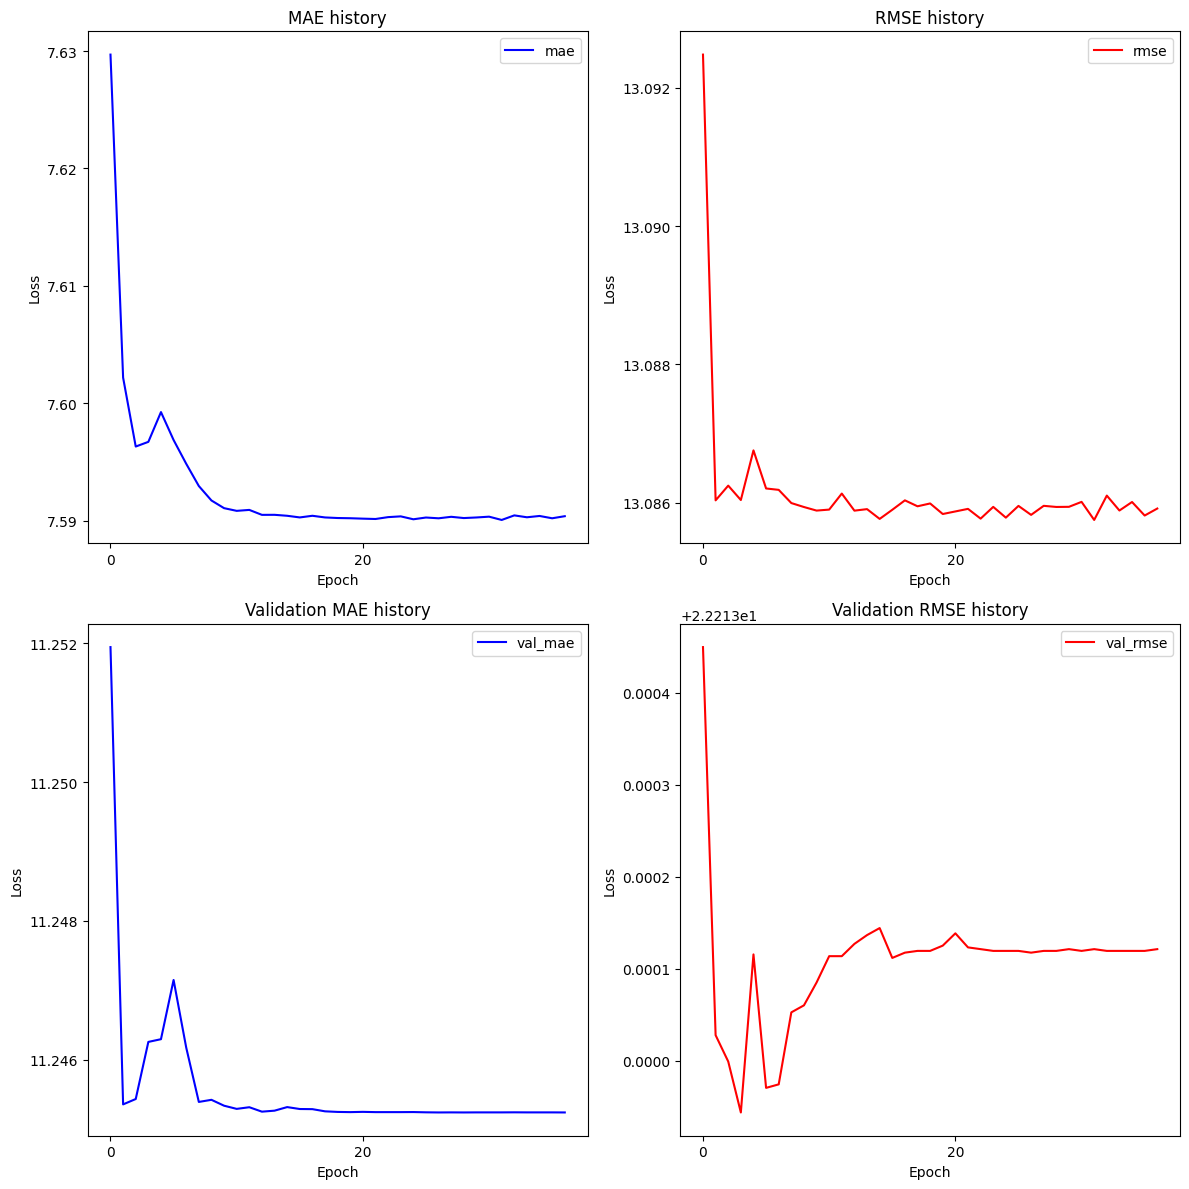

In [27]:
import simulate_trade

def main():
    # Instantiate a StandardScaler
    scaler = StandardScaler()

    # # Define the types of models we want to use
    model_types = ['transformer']

    # Define the types of models we want to use
    #model_types = ['mlp', 'cnn', 'lstm', 'stacked_lstm', 'gru', 'bilstm','stacked_bilstm', 'transformer']

    # Create an empty dataframe to store metrics
    df_metrics = pd.DataFrame(columns=['window_size','model', 'epochs', 'mae', 'rmse', 'trading_profit'])

    # Loop over all defined window sizes
    for window_size in WINDOW_SIZES:
        # Define the path to the training data file
        TRAIN_FILE = BASE_DIR + FILE_PATTERN.format(window_size)
        # Preprocess the data
        X_train, X_valid, X_test, Y_train, Y_valid, Y_test, Y_date_price = preprocess_data(TRAIN_FILE, window_size)

        # Fit the scaler to the training data
        scaler.fit(X_train)

        # Normalize and reshape the training, validation, and testing data
        X_train, X_valid, X_test = normalize_and_reshape(X_train, scaler, window_size), normalize_and_reshape(X_valid, scaler, window_size), normalize_and_reshape(X_test, scaler, window_size)
        Y_train, Y_valid, Y_test = Y_train.values, Y_valid.values, Y_test.values

        # Loop over all defined model types
        for model_type in model_types:
            # Define the shape of the input data
            input_shape = (X_train.shape[1], X_train.shape[2])

            # Create EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau callbacks
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_LR=1.0**(-5))
            ]

            # Create the model based on the model type
            if model_type == 'cnn':
                model = create_cnn_model(input_shape, HIDDEN_LAYER_SIZE, LR)
            elif model_type == 'lstm':
                model = create_lstm_model(input_shape, HIDDEN_LAYER_SIZE, LR)
            elif model_type == 'bilstm':
                model = create_bilstm_model(input_shape, HIDDEN_LAYER_SIZE, LR)
            elif model_type == 'stacked_bilstm':
                model = create_stacked_bilstm_model(input_shape, HIDDEN_LAYER_SIZE, LR)
            elif model_type == 'stacked_lstm':
                model = create_stacked_lstm_model(input_shape, HIDDEN_LAYER_SIZE, LR)
            elif model_type == 'gru':
                model = create_gru_model(input_shape, HIDDEN_LAYER_SIZE, LR)
            elif model_type == 'transformer':
                model = create_transformer_model(input_shape, HIDDEN_LAYER_SIZE, LR)
            else:
                model = create_mlp_model(input_shape, HIDDEN_LAYER_SIZE, LR)  # default is MLP

            # Train and evaluate the model
            if model_type == 'transformer':
                history = model.fit([X_train, X_train], Y_train,
                            validation_data=([X_valid, X_valid], Y_valid),
                            epochs=NUM_EPOCHS,
                            batch_size=BATCH_SIZE,
                            callbacks=callbacks)
                loss, mae, rmse  = model.evaluate([X_test, X_test], Y_test, verbose=2)
                print(f"Test Loss: {loss}, Test MAE: {mae}, Test RMSE: {rmse}")
            else:
                history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
                loss, mae, rmse  = model.evaluate(X_test, Y_test, verbose=2)
                print(f"Test Loss: {loss}, Test MAE: {mae}, Test RMSE: {rmse}")

            # Plot the training history
            plot_history(history, 'history_{}_{}.png'.format(window_size, model_type))

            # Use the model to simulate trading
            final_value = simulate_trade.plot_result(X_test, Y_test, Y_date_price, model, window_size, model_type)

            # Store the metrics in the metrics dataframe
            df_metrics = df_metrics.append({
                'window_size': window_size,
                'model': model_type,
                'epochs': len(history.history['loss']),
                'mae': mae,
                'rmse': rmse,
                'trading_profit': final_value  # Assumes final_value is calculated in the simulate_trading function or elsewhere.
            }, ignore_index=True)

    # Save the metrics dataframe as a CSV file
    df_metrics.to_csv('model_metrics.csv', index=False)

# Run the main function if this script is run as the main program
if __name__ == "__main__":
    main()

